# How to Train YOLOv7 on a Custom Dataset

This tutorial is based on the [YOLOv7 repository](https://github.com/WongKinYiu/yolov7) by WongKinYiu. This notebook shows training on **your own custom objects**. Many thanks to WongKinYiu and AlexeyAB for putting this repository together.


### **Accompanying Blog Post**

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv7](https://blog.roboflow.com/yolov7-custom-dataset-training-tutorial/), concurrently.

### **Steps Covered in this Tutorial**

To train our detector we take the following steps:

* Install YOLOv7 dependencies
* Load custom dataset from Roboflow in YOLOv7 format
* Run YOLOv7 training
* Evaluate YOLOv7 performance
* Run YOLOv7 inference on test images
* OPTIONAL: Deployment
* OPTIONAL: Active Learning


## Roboflow Universe

Need data for your project? Before spending time on annotating, check out Roboflow Universe, a repository of more than 200,000 open-source datasets that you can use in your projects. You'll find datasets containing everything from annotated cracks in concrete to plant images with disease annotations.


[![Roboflow Universe](https://media.roboflow.com/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)

## Preparing a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let me show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Keep in mind to choose the right project type. In our case, Object Detection.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/creating-project.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929799852"
  >
</div>

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/uploading-images.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672929808290"
  >
</div>

### Step 3: Labeling

If you only have images, you can label them in [Roboflow Annotate](https://docs.roboflow.com/annotate).

<div align="center">
  <img
    width="640"
    src="https://user-images.githubusercontent.com/26109316/210901980-04861efd-dfc0-4a01-9373-13a36b5e1df4.gif"
  >
</div>

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/generate-new-version.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1673003597834"
  >
</div>

### Step 5: Exporting dataset

Once the dataset version is generated, we have a hosted dataset we can load directly into our notebook for easy training. Click `Export` and select the `YOLO v5 PyTorch` dataset format.

<div align="center">
  <img
    width="640"
    src="https://media.roboflow.com/preparing-custom-dataset-example/export.gif?ik-sdk-version=javascript-1.4.3&updatedAt=1672943313709"
  >
</div>


#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
!nvidia-smi

In [ ]:
# Download YOLOv7 repository and install requirements

# !git clone https://github.com/WongKinYiu/yolov7
# %cd yolov7
# !pip install -r requirements.txt

# current version of YOLOv7 is not compatible with pytorch>1.12.1 and numpy>1.20.1
# until the appropriate changes get made to the main repository, we will be using a fork containing the patched code
# you can track the progress here: https://github.com/roboflow/notebooks/issues/27
!git clone https://github.com/SkalskiP/yolov7.git
%cd yolov7
!git checkout fix/problems_associated_with_the_latest_versions_of_pytorch_and_numpy
!pip install -r requirements.txt

# Download Correctly Formatted Custom Data

Next, we'll download our dataset in the right format. Use the `YOLOv7 PyTorch` export. Note that this model requires YOLO TXT annotations, a custom YAML file, and organized directories. The roboflow export writes this for us and saves it in the correct spot.


In [ ]:
# REPLACE with your custom code snippet generated above

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR API KEY")
project = rf.workspace("YOUR-WORKSPACE").project("YOUR-PROJECT")
dataset = project.version(1).download("yolov7")

# Begin Custom Training

We're ready to start custom training.

NOTE: We will only modify one of the YOLOv7 training defaults in our example: `epochs`. We will adjust from 300 to 100 epochs in our example for speed. If you'd like to change other settings, see details in [our accompanying blog post](https://blog.roboflow.com/yolov7-custom-dataset-training-tutorial/).

In [ ]:
# download COCO starting checkpoint
%cd /content/yolov7
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt

In [ ]:
# run this cell to begin training
%cd /content/yolov7
!python train.py --batch 16 --epochs 55 --data {dataset.location}/data.yaml --weights 'yolov7_training.pt' --device 0 


# Evaluation

We can evaluate the performance of our custom training using the provided evalution script.

Note we can adjust the below custom arguments. For details, see [the arguments accepted by detect.py](https://github.com/WongKinYiu/yolov7/blob/main/detect.py#L154).

In [ ]:
# Run evaluation
!python detect.py --weights runs/train/exp/weights/best.pt --conf 0.1 --source {dataset.location}/test/images


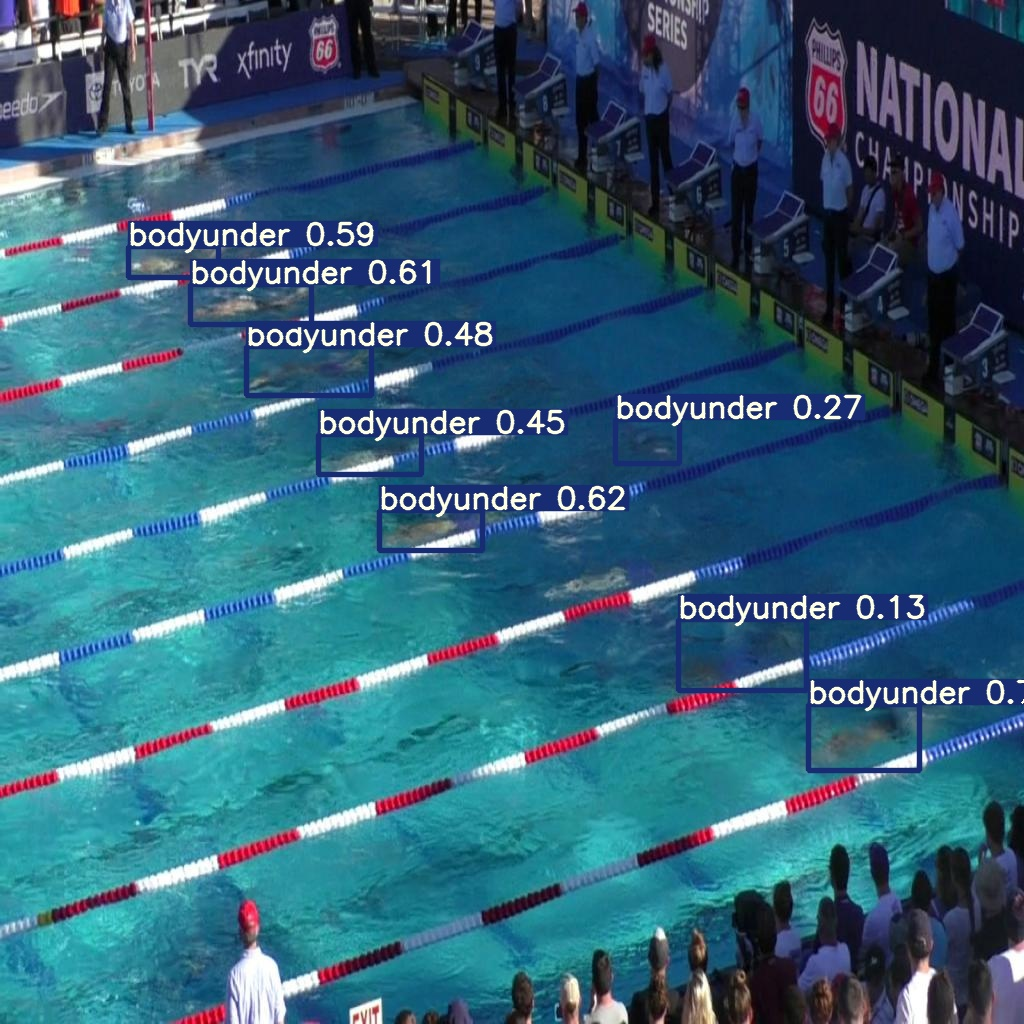

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
for imageName in glob.glob('/content/yolov7/runs/detect/exp/*.jpg'): #assuming JPG
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1
    

# Reparameterize for Inference

https://github.com/WongKinYiu/yolov7/blob/main/tools/reparameterization.ipynb

## Deploy Model on Roboflow

Once you have finished training your YOLOv7 model, you’ll have a set of trained weights ready for use. These weights will be in the `/content/runs/train/exp/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) supports uploading YOLOv7 weights.

**Before you run this code, make sure you create a new Version in the Roboflow dashboard following the instructions we covered earlier. Fill in your project name, workspace, and version number below.**

[Learn how to retrieve your project ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids)
[Learn how to retrieve your API key.](https://docs.roboflow.com/api-reference/authentication#retrieve-an-api-key)

In [ ]:
rf = Roboflow(api_key="YOUR_API_KEY")
project = rf.workspace("workspace").project("project")
dataset = project.version(1)

project.version(dataset.version).deploy(model_type="yolov7", model_path=f"/content/runs/train/exp/weights/")

# Deploy Your Model to the Edge

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device. You can deploy applications using the [Inference Docker containers](https://inference.roboflow.com/quickstart/docker/) or the pip package.

For example, to install Inference on a device with an NVIDIA GPU, we can use:

```
docker pull roboflow/roboflow-inference-server-gpu
```

Then we can run inference via HTTP:

```python
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""
iou_threshold = 0.5

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_threshold,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()
```

Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Also, set the URL of an image on which you want to run inference. This can be a local file.

_To use your YOLOv5 model commercially with Inference, you will need a Roboflow Enterprise license, through which you gain a pass-through license for using YOLOv5. An enterprise license also grants you access to features like advanced device management, multi-model containers, auto-batch inference, and more._

# Next steps

Congratulations, you've trained a custom YOLOv7 model! Next, start thinking about deploying and [building an MLOps pipeline](https://docs.roboflow.com) so your model gets better the more data it sees in the wild.